In [ ]:
# This will load the dataset.You will see a folder called ALL in your workspace.
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/CovidDetec.zip"
!unzip -qo CovidDetec.zip 
!rm CovidDetec.zip

--2021-03-21 00:23:15--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/CovidDetec.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.68
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3479943 (3.3M) [application/zip]
Saving to: ‘CovidDetec.zip’

CovidDetec.zip      100%[===================>]   3.32M  1.95MB/s    in 1.7s    

2021-03-21 00:23:18 (1.95 MB/s) - ‘CovidDetec.zip’ saved [3479943/3479943]



In [ ]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import cv2

import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, SeparableConv2D,BatchNormalization, Conv2D, InputLayer

In [ ]:
path = "CovidDetec/MS/Train"
labels=["Covid","Normal"]

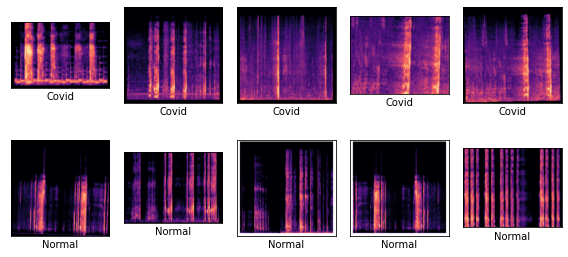

In [ ]:
fig, axs = plt.subplots(len(labels), 5, figsize = (8,4))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

In [ ]:
# Data agumentation on train and test

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15)

test_datagen = ImageDataGenerator(rescale = 1./255)

# create dataset train
train_generator = train_datagen.flow_from_directory(path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)


Found 60 images belonging to 2 classes.


In [ ]:
# Create test data set
test_generator= test_datagen.flow_from_directory("/content/CovidDetec/MS/Test",
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 10 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(GlobalAveragePooling2D())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 6)       168       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 16)      880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               2040      
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

In [ ]:
#define the metrics to evaluate the perfomance
MyList = ["accuracy"]
MyList += [Recall(class_id = i) for i in range(len(labels))] 
MyList += [Precision(class_id = i) for i in range(len(labels))]



In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = MyList)

In [ ]:
history = model.fit(train_generator,validation_data=test_generator,epochs=8)

Epoch 1/8
4/4 [==============================] - 4s 721ms/step - loss: 0.6918 - accuracy: 0.4562 - recall_4: 1.0000 - recall_5: 0.0000e+00 - precision_4: 0.4562 - precision_5: 0.0000e+00 - val_loss: 0.6881 - val_accuracy: 0.5000 - val_recall_4: 1.0000 - val_recall_5: 0.0000e+00 - val_precision_4: 0.5000 - val_precision_5: 0.0000e+00
Epoch 2/8
4/4 [==============================] - 2s 555ms/step - loss: 0.6896 - accuracy: 0.5881 - recall_4: 1.0000 - recall_5: 0.3632 - precision_4: 0.4980 - precision_5: 0.8000 - val_loss: 0.6868 - val_accuracy: 0.9000 - val_recall_4: 0.8000 - val_recall_5: 1.0000 - val_precision_4: 1.0000 - val_precision_5: 0.8333
Epoch 3/8
4/4 [==============================] - 2s 537ms/step - loss: 0.6840 - accuracy: 0.9571 - recall_4: 0.9431 - recall_5: 0.9771 - precision_4: 0.9692 - precision_5: 0.9398 - val_loss: 0.6829 - val_accuracy: 1.0000 - val_recall_4: 1.0000 - val_recall_5: 1.0000 - val_precision_4: 1.0000 - val_precision_5: 1.0000
Epoch 4/8
4/4 [============

Text(0.5, 1.0, 'Training and Validation Accuracy')

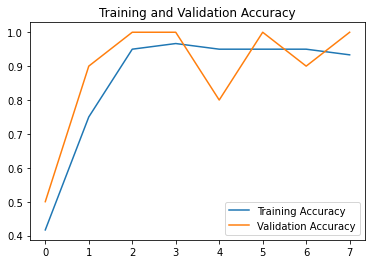

In [ ]:
# Plotting training and validation accuracy per epoch

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

epochs = range(len(train_acc)) 

plt.plot(epochs, train_acc)
plt.plot(epochs, valid_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Training and Validation Accuracy")

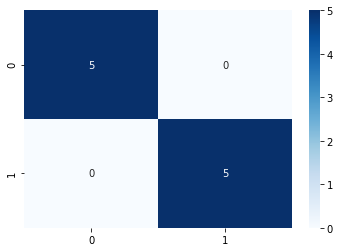

In [ ]:

# Obtain predictions
pred = model.predict(test_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = test_generator.classes
    
# Now plot matrix
cm = confusion_matrix(actual, pred, labels = [0, 1])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()

In [ ]:
# Classification Report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
model.save("Covid_model.h5")